# Automatic Blog Generator

In this project, we will be  combining OpenAi with a document a page the lives on the internet(GitHub).

<h4>Setup Github Account</h4>
<ul>
    <li>Create a new public repository on github using the format: username.github.io</li>
 <li>Clone the repository</li>
 <li>Create an index.html file</li>
 <li>Add some content to the index file</li>
 <li>Push changes made and go to https://username.github.io to view document on the web</li>
    </ul>


In [28]:
import openai
import os

In [29]:
from getpass import getpass
openai.api_key=getpass()

········


In [30]:
#Install the GitPython library. It allows us to make git calls within python code
!pip3 install GitPython

In [31]:
# Import Repo(Git repository) and set repo path as variables
from git import Repo

In [32]:
#Import Path functionality-This allows us to easily set paths
from pathlib import Path

In [33]:
pwd

'/Users/evelyn.nomayo/GitHub/project_gpt/gpt_env/etaNomayo.github.io'

In [34]:
PATH_TO_BLOG_REPO=Path('/Users/evelyn.nomayo/GitHub/project_gpt/gpt_env/etaNomayo.github.io/.git')

In [35]:
PATH_TO_BLOG_REPO.parent

PosixPath('/Users/evelyn.nomayo/GitHub/project_gpt/gpt_env/etaNomayo.github.io')

In [36]:
PATH_TO_BLOG=PATH_TO_BLOG_REPO.parent

In [37]:
#Create a sub directory called content
PATH_TO_BLOG/"content"

PosixPath('/Users/evelyn.nomayo/GitHub/project_gpt/gpt_env/etaNomayo.github.io/content')

In [38]:
#Assign a variable to the path to blog
PATH_TO_CONTENT= PATH_TO_BLOG/"content"

In [39]:
#There is actually no content folder yet, so lets create one
PATH_TO_CONTENT.mkdir(exist_ok=True, parents=True)

# Function to automatically update web page 

Now that we've established our file path, let's verify that we can utilize Git to automate updates and push changes to the blog. To achieve this, we'll create a function that can handle adding, committing, and pushing changes from within Python

In [40]:
# Function to update blog
def update_blog(commit_message='The Blog has just been updated'):
    #Sync to a reposotory using the gitPython library Repo
    repo=Repo(PATH_TO_BLOG_REPO)
    #Call the git add command to add new update vis the repo path
    repo.git.add(all=True)
    #git commit -m "The Blog has just been updated"
    repo.index.commit(commit_message)
    #git push
    origin = repo.remote(name='origin')
    origin.push()
    

In [41]:
#let us check if this works using a random text to uodate the blog post
randon_text_string ="Just testing here, note that this will replace the original content"

In [42]:
with open(PATH_TO_BLOG/"index.html", 'w') as f:
    f.write(randon_text_string)

In [43]:
update_blog()

# Function to automatically create HTML pages

The function will have the ability to generate HTML pages automatically and complete with placeholders for text and images. These placeholders will later be populated with data retrieved from OpenAI API calls. The pages will be pushed to the content directory created above

In [44]:
#Function to create new blog pages
#import the shutil utility to help with copying and moving files, as well as archiving utilities.

import shutil
def create_new_blog(title, content, cover_image):
    cover_image =Path(cover_image)
    #Get a list of files and count the number of html files in the content directory
    files =len(list(PATH_TO_CONTENT.glob(".html")))
    new_title = f"(files+1).html"
    path_to_new_content = PATH_TO_CONTENT/new_title
    
    #copy cover image and put it in the path to content
    
    shutil.copy(cover_image, PATH_TO_CONTENT)
    if not os.path.exists(path_to_new_content):
        with open(path_to_new_content, "w") as f:
            f.write("<!DOCTYPE html>\n")
            f.write("<html>\n")
            f.write("<head>\n")
            f.write(f"<title> {title} </title>\n")
            f.write("</head>\n")
            
            f.write("<body>\n")
            f.write(f"<img src='{cover_image.name}' alt='Cover Image'> <br />\n")
            f.write(f"<h1> {title} </h1>")
            f.write(content.replace("\n", "<br />\n"))
            f.write("</body>\n")
            f.write("</html>\n")
            print("Blog created")
    return path_to_new_content
   # else:
    #        raise FileExistsError('This file already exsist, please check the name of the file! Aborting....')


In [45]:
path_to_new_content = create_new_blog('Test_title','Randon text','accenture.svg')

In [46]:
print(path_to_new_content)

/Users/evelyn.nomayo/GitHub/project_gpt/gpt_env/etaNomayo.github.io/content/(files+1).html


We will automate the process of adding a link to all blog posts on the index page using the library known as Beautiful Soup. This will involve creating a list on the index page that contains links to all blog posts

In [47]:
#Install beautifulsoup4: used for web scraping purposes to extract data from HTML and XML documents. It provides a simple and efficient way to navigate, search, and modify the parsed HTML or XML data.
!pip install beautifulsoup4

In [48]:
from bs4 import BeautifulSoup as Soup

In [49]:
with open(PATH_TO_BLOG/"index.html") as index:
    soup = Soup(index.read())

In [50]:
str(soup)

'<html><body><p>Just testing here, note that this will replace the original content</p></body></html>'

Now let us check for duplicate links and pass in the path to the new content

In [51]:
def check_for_duplicate_links(path_to_new_content, links):
    urls = [str(link.get("href")) for link in links]
    content_path = str(Path(*path_to_new_content.parts[-2:]))
    return content_path in urls

Now lets write to the index file

In [52]:
def write_to_index(path_to_new_content):
    with open(PATH_TO_BLOG/"index.html") as index:
        soup = Soup(index.read())

    links = soup.find_all("a")
    
    if not links:
        # There are no links in the index.html file yet
        # Create a new <a> tag to add to the end of the file
        link_to_new_blog = soup.new_tag("a", href=Path(*path_to_new_content.parts[-2:]))
        link_to_new_blog.string = path_to_new_content.name.split(".")[0]
        soup.append(link_to_new_blog)
    else:
        last_link = links[-1]
        if check_for_duplicate_links(path_to_new_content, links):
            raise ValueError("Link already exists!")
        
        link_to_new_blog = soup.new_tag("a", href=Path(*path_to_new_content.parts[-2:]))
        link_to_new_blog.string = path_to_new_content.name.split(".")[0]
        last_link.insert_after(link_to_new_blog)
    
    with open(PATH_TO_BLOG/"index.html", "w") as f:
        f.write(str(soup.prettify(formatter='html')))
        


In [53]:
write_to_index(path_to_new_content)

In [54]:
update_blog()

# Use GPT to create the blog post!

To achieve the best outcomes using GPT, it is advisable to provide details about the background of the blog post. Furthermore, a compelling and catchy title can also be beneficial.

In [61]:
def create_prompt(title):
    prompt = """Interoperability in Blockchain and Performance optimisation with AI
 
 Biography
 I am a PhD Fellow researching Interoperability and Perforamce Optimisation in Blockchain!


 Blog

 April 25, 2023
 Title: Challenges in interoperability in Blockchain
 tags: Blockchain, AI, IoT
 Summary:  A talk about the issues with interoperability in Blockchain and how machine learning can be used to improve performance.
 Full text: """.format(title)
    return prompt

In [81]:
title = "Blockchain interoperability"
print(create_prompt(title))

Interoperability in Blockchain and Performance optimisation with AI
 
 Biography
 I am a PhD Fellow researching Interoperability and Perforamce Optimisation in Blockchain!


 Blog

 April 25, 2023
 Title: Challenges in interoperability in Blockchain
 tags: Blockchain, AI, IoT
 Summary:  A talk about the issues with interoperability in Blockchain and how machine learning can be used to improve performance.
 Full text: 


In [83]:
response = openai.Completion.create(engine="text-davinci-003",
                                            prompt=create_prompt(title),
                                            max_tokens=1000,  # we increased the tokens to get a longer blog post
                                            temperature=0.7)

In [84]:
blog_content= response['choices'][0]['text']

In [85]:
print(blog_content)


The blockchain technology is a revolutionary way to store and transfer data in a distributed ledger. While the technology offers many advantages and promises, it is not without its own set of challenges. One of the most pressing issues is interoperability, or the ability of different blockchains to communicate and exchange data. This is a crucial issue as it affects the ability of blockchains to work together and share data. 

Interoperability is an important aspect of blockchain technology and it is necessary for successful operation. To ensure efficient and secure communication, it is important to have a standard protocol that all blockchains can use. At the moment, there are several protocols being developed, but none have been adopted as a universal standard. 

In addition to the need for a standard protocol, there is also a need for better performance. Blockchains can be very slow and expensive to operate, which can hamper their usability. To address this problem, artificial inte

In [92]:
#Create a function to get related image for the blog
def dalle2_prompt(title):
    prompt=f"3d pixel picture showing{title}"
    return prompt
    

In [93]:
image_prompt= dalle2_prompt(title)

In [94]:
image_prompt

'3d pixel picture showingBlockchain interoperability'

In [96]:
response = openai.Image.create(
  prompt=image_prompt,
  n=1,
  size="1024x1024"
)

In [97]:
image_url = response['data'][0]['url']

In [99]:
image_url

'https://oaidalleapiprodscus.blob.core.windows.net/private/org-w4tSBOrbAp7FrfVHztGvvJqa/user-N3a1cEtIiqpN4l9ZEgsGDH01/img-tdew856mZ8tnINPYTLN9P20K.png?st=2023-04-25T00%3A12%3A46Z&se=2023-04-25T02%3A12%3A46Z&sp=r&sv=2021-08-06&sr=b&rscd=inline&rsct=image/png&skoid=6aaadede-4fb3-4698-a8f6-684d7786b067&sktid=a48cca56-e6da-484e-a814-9c849652bcb3&skt=2023-04-25T01%3A02%3A43Z&ske=2023-04-26T01%3A02%3A43Z&sks=b&skv=2021-08-06&sig=cFu9K57AEXxwTPpW75bJu6I/gtw2/aIoap9M7ePDo4w%3D'

In [100]:
def save_image(image_url, file_name):
    image_res = requests.get(image_url, stream = True)
    
    if image_res.status_code == 200:
        with open(file_name,'wb') as f:
            shutil.copyfileobj(image_res.raw, f)
    else:
        print("Error downloading image!")
    return image_res.status_code

In [101]:
save_path = "title2.png"

In [102]:
import requests

save_image(image_url, save_path)

200

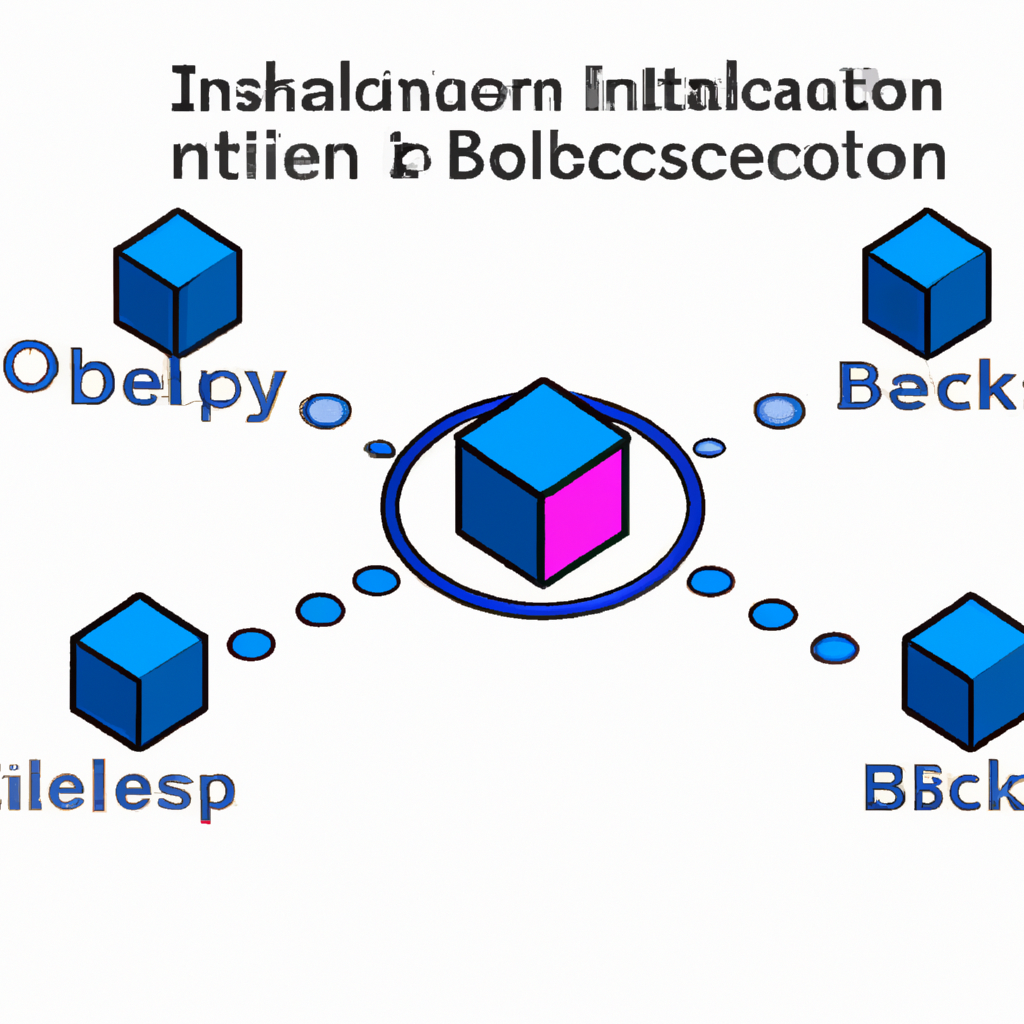

In [104]:
from PIL import Image
Image.open(save_path)

In [105]:
blog_content

'\nThe blockchain technology is a revolutionary way to store and transfer data in a distributed ledger. While the technology offers many advantages and promises, it is not without its own set of challenges. One of the most pressing issues is interoperability, or the ability of different blockchains to communicate and exchange data. This is a crucial issue as it affects the ability of blockchains to work together and share data. \n\nInteroperability is an important aspect of blockchain technology and it is necessary for successful operation. To ensure efficient and secure communication, it is important to have a standard protocol that all blockchains can use. At the moment, there are several protocols being developed, but none have been adopted as a universal standard. \n\nIn addition to the need for a standard protocol, there is also a need for better performance. Blockchains can be very slow and expensive to operate, which can hamper their usability. To address this problem, artificia

In [106]:
path_to_new_content = create_new_blog(title, blog_content, save_path)

In [107]:
write_to_index(path_to_new_content)